In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [19]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

def plot(time, series, format="-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("TIME")
    plt.ylabel("VALUE")
    plt.grid(True)

def trend(time, slope = 0):
    return slope * time
    
def seasonal_pattern(season_time):
    return np.where(season_time < 0.5, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period = 365, amplitude = 1, phase = 0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
    rd = np.random.RandomState(seed)
    return rd.randn(len(time)) * noise_level

time = np.arange(5 * 365 + 1, dtype = "float32")
baseline = 10
series = trend(time, 0.2)
amplitude = 50
slope = 0.05
noise_level = 5

series = baseline + trend(time, slope) + seasonality(time, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]

time_validtn = time[split_time:]
x_validtn = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [27]:
dt_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer=tf.keras.optimizers.RMSprop()) 
model.fit(dt_set, epochs = 100, verbose = 1)

Epoch 1/100
31/31 [==============================] - 0s 9ms/step - loss: 1373.0802
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 369.9040
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 243.5381
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 225.2569
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 208.0946
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 196.8276
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 185.9296
Epoch 8/100
31/31 [==============================] - 0s 3ms/step - loss: 177.7253
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 170.1885
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 165.7552
Epoch 11/100
31/31 [==============================] - 0s 3ms/step - loss: 161.6984
Epoch 12/100
31/31 [==============================] - 0s 3ms/step - loss: 157.1797
Epoch 13/100

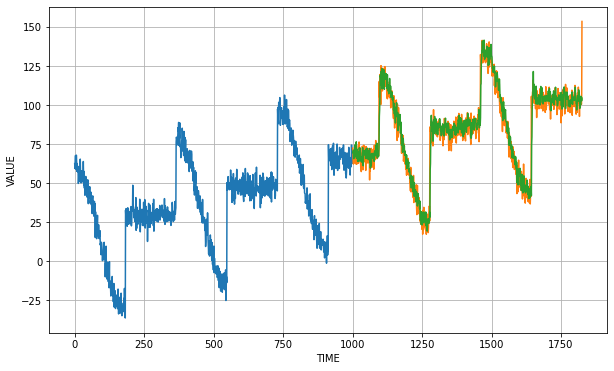

In [31]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time +window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0,0]
plt.figure(figsize=(10,6))
plot(time_train,x_train)
plot(time_validtn,x_validtn)
plot(time_validtn, results)